<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries used

In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, f1_score, multilabel_confusion_matrix,
                             accuracy_score, hamming_loss, jaccard_score, make_scorer)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.svm import SVC

This notebook is a continuation of the notebook "2_label_step_1_to_3", which describes the pre-processing and exploration of the data. 

This notebook using the same dataset, proceeds to construct predictive models and evaluate their performance.

The data used represents the results of numerous applications of mass spectrometry on the bacteria S. Aureus.

The data has been synthesized into blocks of 20 Da, ranging from 2000 to 8000, totalling 300 columns of real non-negative data. There exists 4 special columns which contain the susceptibility of the bacteria to certain antibiotics, which can be S (susceptible) or R (resistant). These 4 columns are the target variables. This turns the problem into a multi-label one, meaning we want to predict multiple variables simultaneously. The target antibiotics are: Oxacillin, Clindamycin, Ceftriaxone, and Fusidic Acid.

This notebook only uses 2 of the 4 antibiotics (Oxacillin and Clindamycin) with the goal of stablishing a point of comparison with the results obtained by the models constructed in the study *"Rapid Antibiotic Resistance Serial Prediction in Staphylococcus aureus Based on Large-Scale MALDI-TOF Data by Applying XGBoost in Multi-Label Learning"*, which only uses those same two antibiotics.

We load the train dataset.

In [2]:
train_data = "splits/train.csv"
train_bac = pd.read_csv(train_data)
train_bac

,2000,2020,2040,2060,2080,2100,2120,2140,2160,2180,...,7860,7880,7900,7920,7940,7960,7980,Oxacillin,Clindamycin,Fusidic acid
0,0.045520,0.049164,0.053732,0.103799,0.070313,0.054133,0.066685,0.062658,0.065464,0.052958,...,0.013030,0.014085,0.013747,0.013751,0.017801,0.019805,0.016569,S,S,S
1,0.017259,0.017404,0.018424,0.021564,0.021515,0.017156,0.018783,0.024013,0.021183,0.020315,...,0.030503,0.031433,0.029932,0.028772,0.031634,0.031223,0.070219,S,S,S
2,0.004456,0.004988,0.005678,0.012892,0.008272,0.005309,0.007186,0.007899,0.007782,0.006989,...,0.027980,0.030444,0.027396,0.030451,0.031686,0.039274,0.092733,S,S,S
3,0.087679,0.079606,0.080376,0.099183,0.088755,0.075990,0.080818,0.072312,0.075789,0.078015,...,0.025271,0.025498,0.024893,0.024923,0.023928,0.028272,0.039272,S,S,S
4,0.002474,0.002419,0.002358,0.004563,0.004108,0.002871,0.002792,0.003716,0.003722,0.003371,...,0.014546,0.014997,0.013014,0.013827,0.014606,0.018225,0.042739,S,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,0.014471,0.014261,0.014812,0.024280,0.017555,0.014864,0.016927,0.022291,0.015765,0.013412,...,0.026568,0.028946,0.027226,0.029400,0.031105,0.035675,0.071416,S,S,S
2717,0.051320,0.043270,0.042688,0.047761,0.044180,0.041507,0.045532,0.052566,0.043973,0.044534,...,0.051332,0.052892,0.051383,0.044976,0.044261,0.055749,0.119627,S,S,S
2718,0.027629,0.026645,0.029737,0.057110,0.039290,0.034540,0.042135,0.042975,0.036420,0.030301,...,0.003987,0.003996,0.003625,0.003666,0.002803,0.004356,0.006031,S,S,S
2719,0.005350,0.006803,0.006776,0.017303,0.009075,0.006464,0.009227,0.012376,0.010396,0.006687,...,0.027414,0.031705,0.027158,0.026610,0.032736,0.038164,0.105793,R,S,S


In [3]:
test_data = "splits/test.csv"
test_bac = pd.read_csv(test_data)
test_bac

,2000,2020,2040,2060,2080,2100,2120,2140,2160,2180,...,7860,7880,7900,7920,7940,7960,7980,Oxacillin,Clindamycin,Fusidic acid
0,0.014347,0.013725,0.015206,0.023032,0.018384,0.016121,0.017941,0.020728,0.017807,0.015219,...,0.005561,0.004898,0.005046,0.004735,0.004648,0.005042,0.008967,S,S,S
1,0.027366,0.028698,0.029379,0.040684,0.034901,0.028935,0.033061,0.028826,0.036905,0.034269,...,0.029313,0.031482,0.032403,0.030731,0.030942,0.033231,0.067030,S,S,S
2,0.025357,0.026799,0.029130,0.049740,0.035863,0.031036,0.036900,0.038249,0.034973,0.027970,...,0.016136,0.018235,0.016387,0.017042,0.017342,0.020363,0.032168,R,R,S
3,0.011295,0.011012,0.013232,0.022377,0.015440,0.015612,0.017093,0.019302,0.016994,0.014742,...,0.014279,0.015619,0.015543,0.014944,0.014158,0.017837,0.026713,S,S,S
4,0.001713,0.001776,0.001870,0.003791,0.002439,0.001883,0.002161,0.002835,0.002208,0.002036,...,0.002608,0.002711,0.003012,0.002873,0.003572,0.004480,0.011630,S,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.019655,0.020175,0.020680,0.028923,0.024443,0.020783,0.022644,0.025358,0.025727,0.022975,...,0.051514,0.051292,0.047783,0.049777,0.057249,0.068132,0.144378,S,S,S
678,0.008677,0.010209,0.011553,0.020474,0.013246,0.011458,0.014925,0.017026,0.016058,0.012146,...,0.032194,0.034559,0.032832,0.033426,0.035958,0.042152,0.085975,S,S,S
679,0.036784,0.034660,0.033805,0.035174,0.035165,0.032170,0.031983,0.027652,0.032046,0.034006,...,0.012221,0.012003,0.013916,0.013668,0.012657,0.016344,0.016691,S,S,S
680,0.002334,0.002334,0.001970,0.001926,0.001852,0.002367,0.002626,0.021128,0.003611,0.002625,...,0.025654,0.032250,0.023861,0.025803,0.027259,0.034843,0.131252,S,S,S


For convenience, we define a variable with the names of the antibiotics to study.

In [4]:
r_labels = ["Oxacillin", "Clindamycin", "Fusidic acid"]

# Step 4 - Model

There's multiple ways to handle multi-label problems. For this experiment, we shall use the same three strategies used by the paper *"Rapid Antibiotic Resistance Serial Prediction in Staphylococcus aureus Based on Large-Scale MALDI-TOF Data by Applying XGBoost in Multi-Label Learning"*, these being **Binary Relevance**, **Classifier Chain** and **Lowest Power Set**.

The resulting models will all be evaluated using the same four metrics: **Hamming Loss**, **Accuracy**, **Jaccard Score** and **F1 Score**. Of these metrics, the previously mentioned paper only used the first three, however, taking into account the significant class imbalance found in the dataset, **F1 Score** has been added to the list and given focus.
___

Before starting to train models, we must separate the labels from the features and slightly transform the data.

First, we separate the labels from the rest of the data (y).

In [5]:
y_train_b = train_bac[r_labels]
y_test_b = test_bac[r_labels]

The previous cell gave us the labels in multiple columns, one for each antibiotic. However, one of the strategies to be used in this experiment is **Lowest Power Set**, which consists in turning a multi-label problem into a uni-label, multi-class one. Meaning, all the target columns are combined into one (similar to the process done in previous steps). Therefore, so that we can train models this way, we make a copy of the label data in which the values of the 2 labels are joined into a single one.

In [6]:
y_train_lps = pd.DataFrame()
y_train_lps["Class"] = train_bac[r_labels].agg(''.join, axis=1)
y_train_lps["Class"] = y_train_lps["Class"].astype(str)

y_test_lps = pd.DataFrame()
y_test_lps["Class"] = test_bac[r_labels].agg(''.join, axis=1)
y_test_lps["Class"] = y_test_lps["Class"].astype(str)

From this point on, the variables to be used in **Binary Relevance** and **Classifier Chain** models shall be noted with "_b" and the ones used in **Lowest Power Set** with "_lps". Variables related specifically to **Classifier Chain** (such as the results of the models trained using that strategy) shall be noted with "_c".

For this experiment, we use feature selection to reduce the amount of features..

The features shall be selected through Recursive Feature Elimination (RFE) with Cross Validation. This recursively eliminates ranks features and eliminates the ones estimated least important, automatically determining the optimal amount of features to keep.

The results of applying RFECV to the dataset have already been obtained in a separate notebook, found alongside this one, called "feature_selection.ipynb". The selected features have been stored in a text file called "selected_features.txt" and, instead of applying RFE again, we shall simply use the features indicated in the mentioned file.

In [7]:
os.chdir("..")
with open("selected_features.txt") as file:
    selected_features = file.read().split(",")
selected_features.pop()
selected_features

['2040',
 '2060',
 '2080',
 '2160',
 '2180',
 '2240',
 '2280',
 '2300',
 '2400',
 '2420',
 '2440',
 '2520',
 '2620',
 '2760',
 '2820',
 '2840',
 '2960',
 '3020',
 '3040',
 '3100',
 '3260',
 '3320',
 '3340',
 '3360',
 '3420',
 '3460',
 '3480',
 '3500',
 '3620',
 '3700',
 '3760',
 '4020',
 '4280',
 '4320',
 '4500',
 '4520',
 '4560',
 '4600',
 '4780',
 '4800',
 '4940',
 '5000',
 '5020',
 '5280',
 '5300',
 '5340',
 '5360',
 '5420',
 '5440',
 '5500',
 '5520',
 '5540',
 '5580',
 '6280',
 '6300',
 '6420',
 '6540',
 '6560',
 '6820',
 '7020',
 '7180',
 '7420',
 '7520',
 '7780',
 '7800']

We keep only the selected features.

In [8]:
X_train = train_bac[selected_features]
X_test = test_bac[selected_features]

Certain models struggle with data that isn't numeric. Therefore, so that no issues arise, we transform all labels to numbers. 

In the multi-label data, "S" shall be replaced by 0, and "R" shall be replaced by 1.

In [9]:
y_train_b = y_train_b.replace("S", 0)
y_train_b = y_train_b.replace("R", 1)

y_test_b = y_test_b.replace("S", 0)
y_test_b = y_test_b.replace("R", 1)

For the multi-class data, we shall use a Label Enconder that shall handle transforming the classes.

In [10]:
lc = LabelEncoder()
lc.fit(y_train_lps.values.ravel())
y_train_lps = lc.transform(y_train_lps.values.ravel())
y_test_lps = lc.transform(y_test_lps.values.ravel())

When required, we can check which class corresponds to each number by doing an inverse transform.

In [11]:
for i in range(2**len(r_labels)):
    print(str(i)+":", lc.inverse_transform([i]))

0: ['RRR']
1: ['RRS']
2: ['RSR']
3: ['RSS']
4: ['SRR']
5: ['SRS']
6: ['SSR']
7: ['SSS']


___

The previously mentioned metrics shall be evaluated using Scikit-learn's implementations, however, some of these calculate their average differently depending on whether or not the labels are uni-label or multi-label. This leads to the **Binary Relevance** and **Classifier Chain** models sometimes having widly different results from the **Lowest Power Set** models.

So that the models' results can be compared appropriately, several wrappers are defined. 

First, functions that convert from multi-label to one-label and vice-versa.

In [12]:
# Transforms a one-label instance into a multi-label one.
def lps_to_multilabel_instance(lps_num):
  inverse = lc.inverse_transform([lps_num])
  multilabel_instance = []
  for result in inverse[0]:
    if result == "S":
      multilabel_instance.append(0)
    else:
      multilabel_instance.append(1)
  return multilabel_instance

# Transforms a list of one-label instances into a multi-label one.
def lps_to_multilabel_list(lps_list):
  multilabel_list = []
  for lps_instance in lps_list:
    multilabel_list.append(lps_to_multilabel_instance(lps_instance))
  return multilabel_list

# Transforms a multi-label instance into a one-label one.
def multilabel_to_lps_instance(multilabel_num):
    lps_instance = ""
    for num in multilabel_num:
        if num == 0:
            lps_instance = lps_instance + "S"
        else:
            lps_instance = lps_instance + "R"
    return lps_instance

# Transforms a list of multi-label instances into a one-label one.
def multilabel_to_lps_list(multilabel_list):
    lps_list = []
    for multilabel_instance in multilabel_list:
        lps_list.append(multilabel_to_lps_instance(multilabel_instance))
    return lps_list


For the multi-label data, **Jaccard Score** and **F1 Score** wrappers are defined, where the metrics are individually calculated for each label and then averaged.

In [13]:
def multilabel_jaccard_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(pred, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=jaccard_score(true[:, column], pred[:, column], average=average, zero_division=0)
        column+=1
    return total/(column)

def multilabel_f1_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(true, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=f1_score(true[:, column], pred[:, column], average=average)
        column+=1
    return total/(column)

For the one-label, multi-class data, a wrapper is defined for **F1 Score** so that optimizers can calculate it properly.

In [14]:
def lps_f1_wrapper(true, pred, average="weighted"):
    non_lps_true = lps_to_multilabel_list(true)
    non_lps_pred = lps_to_multilabel_list(pred)
    return multilabel_f1_wrapper(non_lps_true, non_lps_pred, average=average)

Finally, so that the results of all the metrics of interest can be observed with ease, a function that calls each of the respective functions is defined.

In [15]:
def report(true, pred):
    if not len(pred.shape) > 1:
        true = lps_to_multilabel_list(true)
        pred = lps_to_multilabel_list(pred)
        
    hl = hamming_loss(true, pred)
    jsw = multilabel_jaccard_wrapper(true, pred, "weighted")
    f1w = multilabel_f1_wrapper(true, pred, "weighted")
    acc = accuracy_score(true, pred)
    
    jsu = multilabel_jaccard_wrapper(true, pred, "macro")
    jssu = jaccard_score(true, pred, average="macro")
    jssw = f1_score(true, pred, average="weighted")
    f1u = multilabel_f1_wrapper(true, pred, "macro")
    f1su = f1_score(true, pred, average="macro")
    f1sw = f1_score(true, pred, average="weighted")

    
    print("Main metrics:")
    print(" Hamming Loss:", hl)
    print(" Accuracy:", acc)
    print(" Jaccard Score (Weighted):", jsw)
    print(" F1 Score (Weighted):", f1w)
    print("================================================")
    print("Other metrics:")
    print(" Jaccard Score (Unweighted):", jsu)
    print(" Jaccard Score (sklearn Unweighted):", jssu)
    print(" Jaccard Score (sklearn Weighted):", jssw)
    print(" F1 Score (Unweighted):", f1u)
    print(" F1 Score (sklearn Unweighted):", f1su)
    print(" F1 Score (sklearn Weighted):", f1sw)
    return hl, acc, jsw, f1w

___
# **SVC**:

The classifier to be used in this experiment is Scikit-learn's implementation of Support Vector Classifier.

___
**Binary relevance**: Evaluates each label one after another, without taking into account any possible correlation. 

SVC does not natively support multi-label classification, so to achieve this, we use Scikit-learn's meta-classifier MultiOutputClassifier, which fits a model for each label.

Hyperarameters are optimized through skopt's BayesSearchCV, which implements a a Bayesian hyperarameters optimization with cross-validation, following an interface similar to that of Scikit-learn's models and optimizers.

* Hyperarameters optimized are C, and Gamma.
* Model is optimized for highest **F1 Score**.
* Random state set to 0 for ease or reproducibility.

In [16]:
opt_b = BayesSearchCV(
    MultiOutputClassifier(SVC()),
    {
        "estimator__C": Real(1e-6, 1000, prior="log-uniform"),
        "estimator__kernel": Categorical(["rbf"]),
        "estimator__gamma": Real(1e-6, 1000, prior="log-uniform")
    },
    n_iter=600,
    cv=5,
    random_state=0,
    n_jobs=5,
    n_points=2,
    scoring=make_scorer(multilabel_f1_wrapper),
    verbose=1
)

opt_b.fit(X_train, y_train_b)

print("Best score:", opt_b.best_score_)
print("Best parameter combination found:", opt_b.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

We then use the model constructed by the parameter optimizer to predict the test data see how it performs.

In [17]:
svm_b = opt_b.best_estimator_
svm_b.fit(X_train, y_train_b)
pred_svm_b = svm_b.predict(X_test)
hl_svm_b, acc_svm_b, js_svm_b, f1_svm_b = report(y_test_b, pred_svm_b)

Main metrics:
 Hamming Loss: 0.10019550342130987
 Accuracy: 0.7463343108504399
 Jaccard Score (Weighted): 0.818470275741784
 F1 Score (Weighted): 0.8768460271353694
Other metrics:
 Jaccard Score (Unweighted): 0.5779050013567263
 Jaccard Score (sklearn Unweighted): 0.2620860189851166
 Jaccard Score (sklearn Weighted): 0.46173861916259057
 F1 Score (Unweighted): 0.6531594656000087
 F1 Score (sklearn Unweighted): 0.3627067735594867
 F1 Score (sklearn Weighted): 0.46173861916259057


We further visualize the results through a confusion matrix.

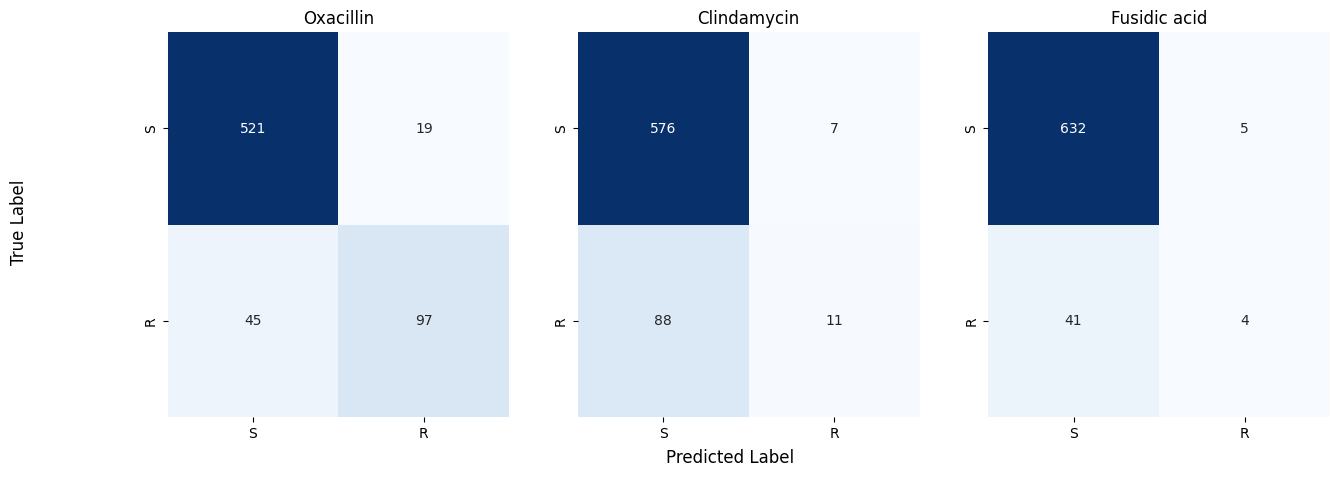

In [18]:
fig, axes = plt.subplots(1, len(r_labels), figsize=(len(r_labels)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_b = multilabel_confusion_matrix(y_test_b, pred_svm_b)

for i in range(len(r_labels)):
  sns.heatmap(ax=axes[i], data=cm_svm_b[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=r_labels[i])

___
**Classifier Chain**: A strategy that attempts to exploit the correlation between labels. Orders the labels and then, for each one, fits the given data plus the predicted values of the labels earlier positions of the chain.

SVC does not natively support this strategy either, so to achieve this, we use Scikit-learn's meta-classifier ClassifierChain.

Once again, hyperparameters are optimized through skopt's BayesSearchCV.

* Hyperarameters optimized are C, and Gamma.
* Model is optimized for highest **F1 Score**.
* Random state set to 0 for ease or reproducibility.

In [19]:
opt_c = BayesSearchCV(
    ClassifierChain(SVC(), random_state=0),
    {
        "base_estimator__C": Real(1e-6, 1000, prior="log-uniform"),
        "base_estimator__kernel": Categorical(["rbf"]),
        "base_estimator__gamma": Real(1e-6, 1000, prior="log-uniform"),
    },
    n_iter=600,
    cv=5,
    random_state=0,
    n_jobs=5,
    n_points=2,
    scoring=make_scorer(multilabel_f1_wrapper),
    verbose=1
)

opt_c.fit(X_train, y_train_b)

print("Best score:", opt_c.best_score_)
print("Best parameter combination found:", opt_c.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

We then use the model constructed by the parameter optimizer to predict the test data see how it performs.

In [20]:
svm_c = opt_c.best_estimator_
svm_c.fit(X_train, y_train_b) 
pred_svm_c = svm_c.predict(X_test)
hl_svm_c, acc_svm_c, js_svm_c, f1_svm_c = report(y_test_b, pred_svm_c)

Main metrics:
 Hamming Loss: 0.10410557184750734
 Accuracy: 0.7390029325513197
 Jaccard Score (Weighted): 0.8156907700897015
 F1 Score (Weighted): 0.8782384292036682
Other metrics:
 Jaccard Score (Unweighted): 0.5830219762512237
 Jaccard Score (sklearn Unweighted): 0.277034698430404
 Jaccard Score (sklearn Weighted): 0.487375637244435
 F1 Score (Unweighted): 0.6677265430335338
 F1 Score (sklearn Unweighted): 0.39443516751484314
 F1 Score (sklearn Weighted): 0.487375637244435


We further visualize the results through a confusion matrix.

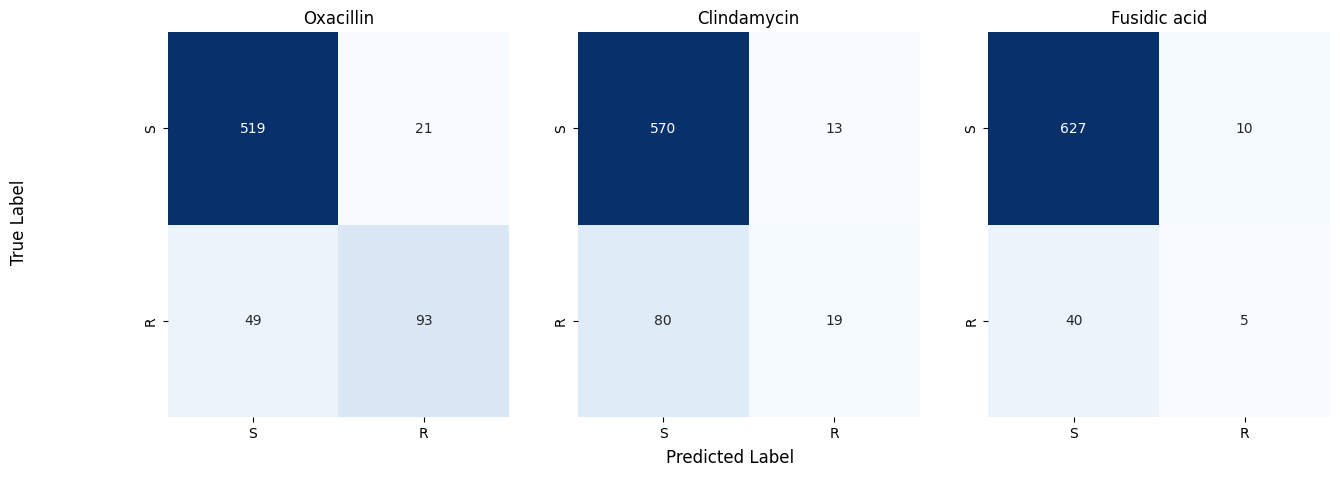

In [21]:
fig, axes = plt.subplots(1, len(r_labels), figsize=(len(r_labels)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_c = multilabel_confusion_matrix(y_test_b, pred_svm_c)

for i in range(len(r_labels)):
  sns.heatmap(ax=axes[i], data=cm_svm_c[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=r_labels[i])

___
**Lowest Power Set**: As mentioned before, this is a strategy that converts the problem from a multi-label one into a uni-label, multi-class one.

SVC supports multi-class classification natively so, this time around, there is no need to use any meta-classifiers.

One last time, hyperparameters are optimized through skopt's BayesSearchCV.

* Hyperarameters optimized are C, and Gamma.
* Model is optimized for highest **F1 Score**.
* Random state set to 0 for ease or reproducibility.

In [22]:
opt_lps = BayesSearchCV(
    SVC(),
    {
        "C": Real(1e-6, 1000, prior="log-uniform"),
        "kernel": Categorical(["rbf"]),
        "gamma": Real(1e-6, 1000, prior="log-uniform"),
    },
    n_iter=600,
    cv=5,
    random_state=0,
    n_jobs=5,
    n_points=2,
    scoring=make_scorer(lps_f1_wrapper),
    verbose=1
)

opt_lps.fit(X_train, y_train_lps)

print("Best score:", opt_lps.best_score_)
print("Best parameter combination found:", opt_lps.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.8696703746844271
Best para

We then use the model constructed by the parameter optimizer to predict the test data see how it performs.

In [23]:
svm_lps = opt_lps.best_estimator_
svm_lps.fit(X_train, y_train_lps)
pred_svm_lps = svm_lps.predict(X_test)
hl_svm_lps, acc_svm_lps, js_svm_lps, f1_svm_lps = report(y_test_lps, pred_svm_lps)

Main metrics:
 Hamming Loss: 0.10606060606060606
 Accuracy: 0.7390029325513197
 Jaccard Score (Weighted): 0.8111883153935113
 F1 Score (Weighted): 0.87414520047107
Other metrics:
 Jaccard Score (Unweighted): 0.5721773930593153
 Jaccard Score (sklearn Unweighted): 0.2569724347865594
 Jaccard Score (sklearn Weighted): 0.46321636634602353
 F1 Score (Unweighted): 0.6558340586607221
 F1 Score (sklearn Unweighted): 0.37163437655240933
 F1 Score (sklearn Weighted): 0.46321636634602353


We further visualize the results through a confusion matrix.

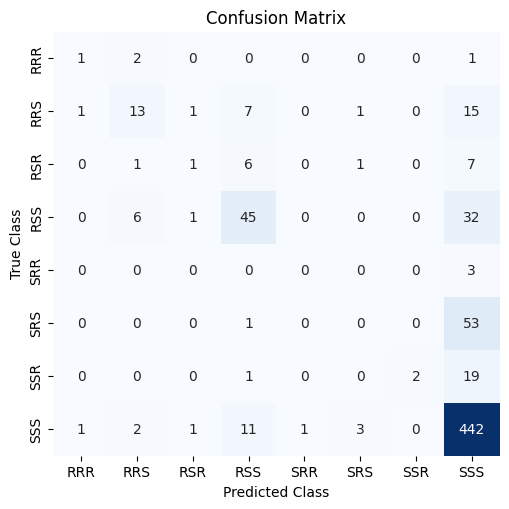

In [24]:
fig, axes = plt.subplots(figsize=(5, 5))
cm_lps = confusion_matrix(y_test_lps, pred_svm_lps)
sns.heatmap(cm_lps, annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=lc.inverse_transform(range(2**len(r_labels))), yticklabels=lc.inverse_transform(range(2**len(r_labels))))
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

___
**Comparison Table** 

Finally, we see the results of all the models, for each metric, consolidated into a single table.

In [25]:
print("Comparison Table:")
print("Strategy         | Hamming Loss        | Accuracy           | Jaccard Score      | F1 Score")
print("Binary Relevance | " + str(hl_svm_b) + " | " + str(acc_svm_b) + " | " + str(js_svm_b) + " | " + str(f1_svm_b))
print("Classifier Chain | " + str(hl_svm_c) + " | " + str(acc_svm_c) + " | " + str(js_svm_c) + " | " + str(f1_svm_c))
print("Lowest Power Set | " + str(hl_svm_lps) + "  | " + str(acc_svm_lps) + " | " + str(js_svm_lps) + " | " + str(f1_svm_lps))

Comparison Table:
Strategy         | Hamming Loss        | Accuracy           | Jaccard Score      | F1 Score
Binary Relevance | 0.10019550342130987 | 0.7463343108504399 | 0.818470275741784 | 0.8768460271353694
Classifier Chain | 0.10410557184750734 | 0.7390029325513197 | 0.8156907700897015 | 0.8782384292036682
Lowest Power Set | 0.10606060606060606  | 0.7390029325513197 | 0.8111883153935113 | 0.87414520047107
